In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-stock-data/GOOG.csv


**Import necessary libraries**

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

**Load CSV and plot it out**

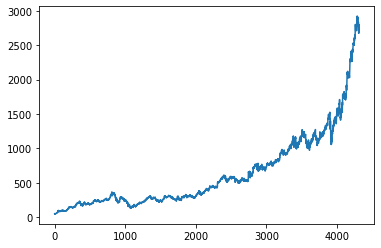

In [12]:
df = pd.read_csv('/kaggle/input/google-stock-data/GOOG.csv')
plt.plot(df['Open'])
plt.show()

**Split dataset into train-test; also set strides**

In [13]:
ds_open = df[['Open']]
train = ds_open [ : 3500 ]
test = ds_open [ 3500 : ]
test = test.reset_index(drop=True)
steps = 50

**Scale the prices down (0,1)**

In [14]:
scale = MinMaxScaler(feature_range = (0, 1))
train_set = scale.fit_transform(train)
test_set = scale.fit_transform(test)

**Preprocessing function to transform test and train splits into LSTM-appropriate inputs and outputs**

In [15]:
def prepDS(data, steps):
    X = []
    y = []
    for i in range( len(data) - steps ):
        X.append(data[ i : i+steps])
        y.append(data[ i + steps, 0 ])
    return np.array(X), np.array(y)

In [16]:
X_train, y_train = prepDS(train_set, steps)
X_test, y_test = prepDS(test_set, steps)

**Build the LSTM model**

In [17]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (steps,1)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 50))
model.add(Dropout(0.2)) 
model.add(Dense(units = 1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(X_train, y_train, epochs = 200, batch_size=80, validation_data=(X_test,y_test))

2021-11-15 19:58:07.008048: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-11-15 19:58:11.588002: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


44/44 [==============================] - 7s 36ms/step - loss: 0.0183 - val_loss: 0.0033
Epoch 2/200
44/44 [==============================] - 1s 12ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 3/200
44/44 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/200
44/44 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 5/200
44/44 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/200
44/44 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/200
44/44 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/200
44/44 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 9/200
44/44 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 10/200
44/44 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 11/20

**Reshape, transform test dataset for prediction**

In [23]:
inputs = ds_open[len(ds_open)-len(test_set)-steps:].values
inputs = inputs.reshape(-1,1)
inputs = scale.transform(inputs)

**Reorganizing into appropriate inputs and outputs for test**

In [24]:
x_test = []
for x in range(steps,len(inputs)):
    x_test.append(inputs[x-steps:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

pred = model.predict(x_test)
pred = scale.inverse_transform(pred)

**Plotting Actual Price against Predicted Price**

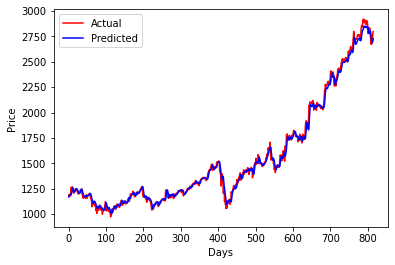

In [25]:
plt.plot(test, color='red', label=f"Actual")
plt.plot(pred, color= 'blue', label=f"Predicted")

plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()